In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/dataset.zip

In [3]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 4.0MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=d3c214a4dfead3aa3287aa4252aa7741c810fbfc80e9a2a64bab13f390d82f43
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [4]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models

import pretrainedmodels.utils as utils

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=0)

In [7]:
import pretrainedmodels

In [8]:
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

In [9]:
# Import xception pre-trained model
model_name = 'xception' # could be fbresnet152 or inceptionresnetv2
model_conv = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
model_conv.eval()
tf_img = utils.TransformImage(model_conv)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [10]:
data_transforms = tf_img

In [ ]:
# data_dir = "/content/dataset_zurich"
# types = ["train", "val", "test"]
# transform_types = ["train", "val"]  # Do not transform the test set (since it is not learned)

# batch_size = 8 # Smaller batch sizes are better for generalization to test set
# shuffle = True
# num_workers = 1

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in transform_types}
# image_datasets["test"] = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms)  # Do not transform test set, only load it. 

# dataloaders = {x: torch.utils.data.DataLoader(
#                 image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in types
#               }

# dataset_sizes = {x: len(image_datasets[x]) for x in types}
# class_names = image_datasets['train'].classes

In [11]:
# Preparing dataset for Stratified Sampling.

import shutil
os.mkdir("train_val")
os.mkdir("train_val/noninteracting")
os.mkdir("train_val/merger")

src_train_merger = "dataset_zurich/train/merger/"
src_val_merger = "dataset_zurich/val/merger/"
src_train_noninteracting = "dataset_zurich/train/noninteracting/"
src_val_noninteracting = "dataset_zurich/val/noninteracting/"

dest_merger = "train_val/merger/"
dest_noninteracting = "train_val/noninteracting/"

for filename in os.listdir(src_train_merger):
  shutil.move(os.path.join(src_train_merger, filename), dest_merger)
for filename in os.listdir(src_val_merger):
  shutil.move(os.path.join(src_val_merger, filename), dest_merger)

for filename in os.listdir(src_train_noninteracting):
  shutil.move(os.path.join(src_train_noninteracting, filename), dest_noninteracting)
for filename in os.listdir(src_val_noninteracting):
  shutil.move(os.path.join(src_val_noninteracting, filename), dest_noninteracting)

# shutil.move("dataset_zurich/train/merger/*", "train_val/merger")
# shutil.move("dataset_zurich/train/noninteracting/*", "train_val/noninteracting")
# shutil.move("dataset_zurich/val/merger/*", "train_val/merger")
# shutil.move("dataset_zurich/val/noninteracting/*", "train_val/noninteracting")

In [12]:
dataset = torchvision.datasets.ImageFolder("train_val", transform=data_transforms)
targets = dataset.targets

In [13]:
from sklearn.model_selection import train_test_split

train_idx, valid_idx = train_test_split(
                          np.arange(len(targets)),
                          test_size=0.2,
                          shuffle=True,
                          stratify=targets
                      )

In [14]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

batch_size = 8 # Smaller batch sizes are better for generalization to test set
num_workers = 1

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler
)
valid_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, num_workers=num_workers, sampler=valid_sampler
)
# Note: shuffle and sampler cannot be used together, they are mutually exclusive.

In [15]:
test_dataset = datasets.ImageFolder(os.path.join("dataset_zurich", "test"), data_transforms)
shuffle = True
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [16]:
dataloaders = {"train": train_loader, "val": valid_loader, "test": test_loader}

In [17]:
class_names = ["merger", "noninteracting"]

In [18]:
types = ["train", "val", "test"]
dataset_sizes = {"train": len(train_idx), "val": len(valid_idx), "test": len(test_dataset)}

In [19]:
dataset_sizes

{'test': 3998, 'train': 9601, 'val': 2401}

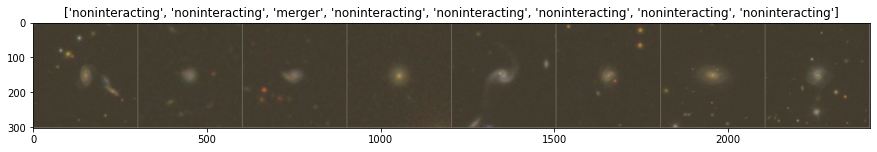

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(15, 40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
merger_count = 0
noninteracting_count = 0

for sample in train_loader.dataset.samples:
  if "merger" in sample[0]:
    merger_count += 1
  elif "noninteracting" in sample[0]:
    noninteracting_count += 1
print(merger_count)
print(noninteracting_count)

4502
7500


In [29]:
def train_model(model, criterion, optimizer, max_epochs_no_improve=4, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epochs_no_improve = 0  # For early stopping

    valid_loss_min = np.Inf
    valid_max_acc = 0.0

    # save_file_name = f"{epoch}.pt"

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase =="train":
              train_losses.append(epoch_loss)
            elif phase == "val":
              valid_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == "valid" and (epoch_loss < valid_loss_min):
              torch.save(model.state_dict(), f"{epoch}.pt")
              # Track improvement
              epochs_no_improve = 0
              valid_loss_min = epoch_loss
              best_epoch = epoch
            elif phase == "valid" and (epoch_loss >= valid_loss_min):
              epochs_no_improve += 1
              if epochs_no_improve >= max_epochs_no_improve:
                model.load_state_dict(torch.load(f"{epoch}.pt"))
                # Attach the optimizer
                model.optimizer = optimizer

                return model, train_losses, valid_losses


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses

In [30]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [24]:
# Hyperparameters from the paper (A1. Main Experiment)
n_epochs = 40
lr = 0.001
momentum = None

In [25]:
# model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.last_linear.in_features
model_conv.last_linear = nn.Linear(num_ftrs, 2)
# model_conv.last_linear_ = nn.Linear(int(num_ftrs/4), 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.last_linear.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [26]:
model_conv

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [27]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model_conv.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_conv.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

20,811,050 total parameters.
4,098 training parameters.


In [31]:
model_conv, train_losses, valid_losses = train_model(model_conv, criterion, optimizer_conv, num_epochs=n_epochs)

Epoch 0/39
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5579 Acc: 0.7168
val Loss: 0.5614 Acc: 0.7097

Epoch 1/39
----------
train Loss: 0.5273 Acc: 0.7454
val Loss: 0.5057 Acc: 0.7493

Epoch 2/39
----------
train Loss: 0.5116 Acc: 0.7515
val Loss: 0.4688 Acc: 0.7851

Epoch 3/39
----------
train Loss: 0.5003 Acc: 0.7642
val Loss: 0.4895 Acc: 0.7609

Epoch 4/39
----------
train Loss: 0.5007 Acc: 0.7587
val Loss: 0.4695 Acc: 0.7868

Epoch 5/39
----------
train Loss: 0.4910 Acc: 0.7669
val Loss: 0.4769 Acc: 0.7809

Epoch 6/39
----------
train Loss: 0.4909 Acc: 0.7649
val Loss: 0.6187 Acc: 0.6943

Epoch 7/39
----------
train Loss: 0.4909 Acc: 0.7656
val Loss: 0.5296 Acc: 0.7401

Epoch 8/39
----------
train Loss: 0.4896 Acc: 0.7649
val Loss: 0.4755 Acc: 0.7763

Epoch 9/39
----------
train Loss: 0.4846 Acc: 0.7728
val Loss: 0.4899 Acc: 0.7655

Epoch 10/39
----------
train Loss: 0.4805 Acc: 0.7696
val Loss: 0.4601 Acc: 0.7851

Epoch 11/39
----------
train Loss: 0.4844 Acc: 0.7724
val Loss: 0.4942 Acc: 0.7613

Epoch 12/39
----------
t

In [32]:
torch.save(model_conv.state_dict(), "NEWEST_xception_40epochs_adam_latest.pth")

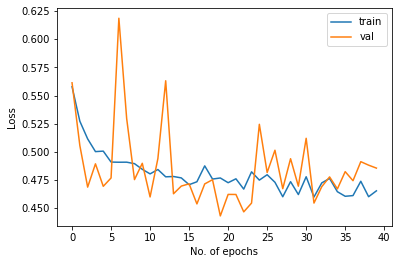

In [33]:
plt.plot(train_losses, label="train");
plt.plot(valid_losses, label="val");

plt.xlabel("No. of epochs");
plt.ylabel("Loss");
plt.legend();

Due to the rapid movements of loss after around 20 epochs, it might be a good idea to decay the learning rate using a `lr_scheduler`. This seems to be commonly done in transfer learning.

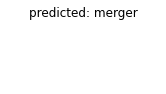

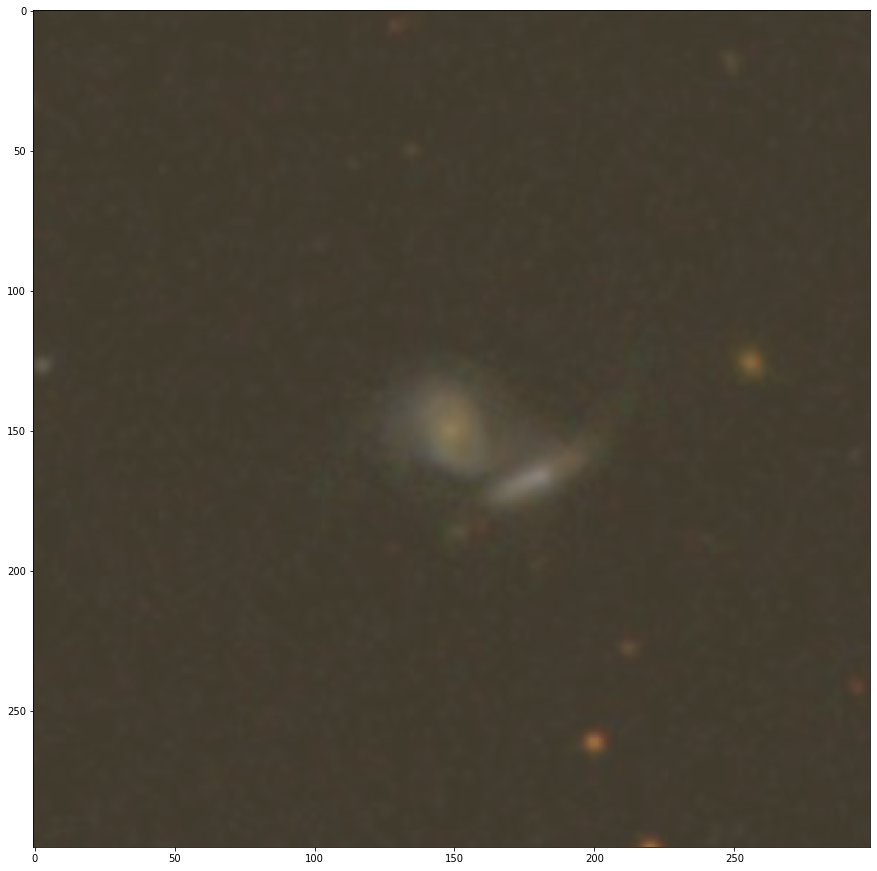

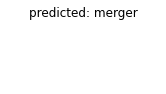

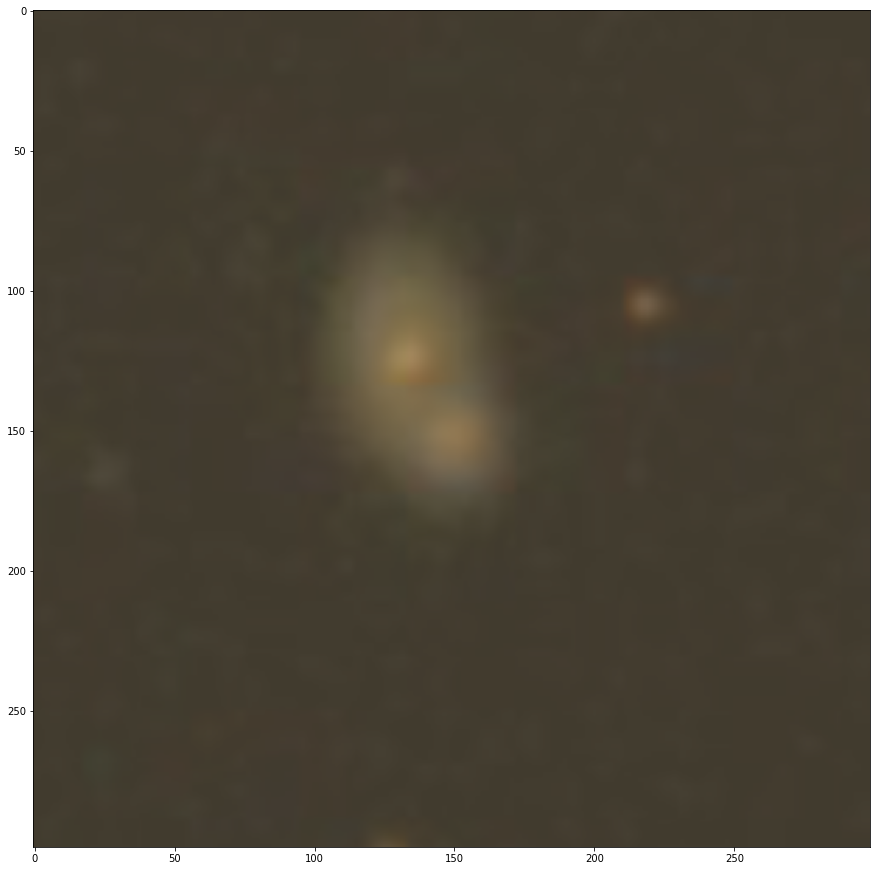

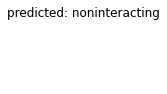

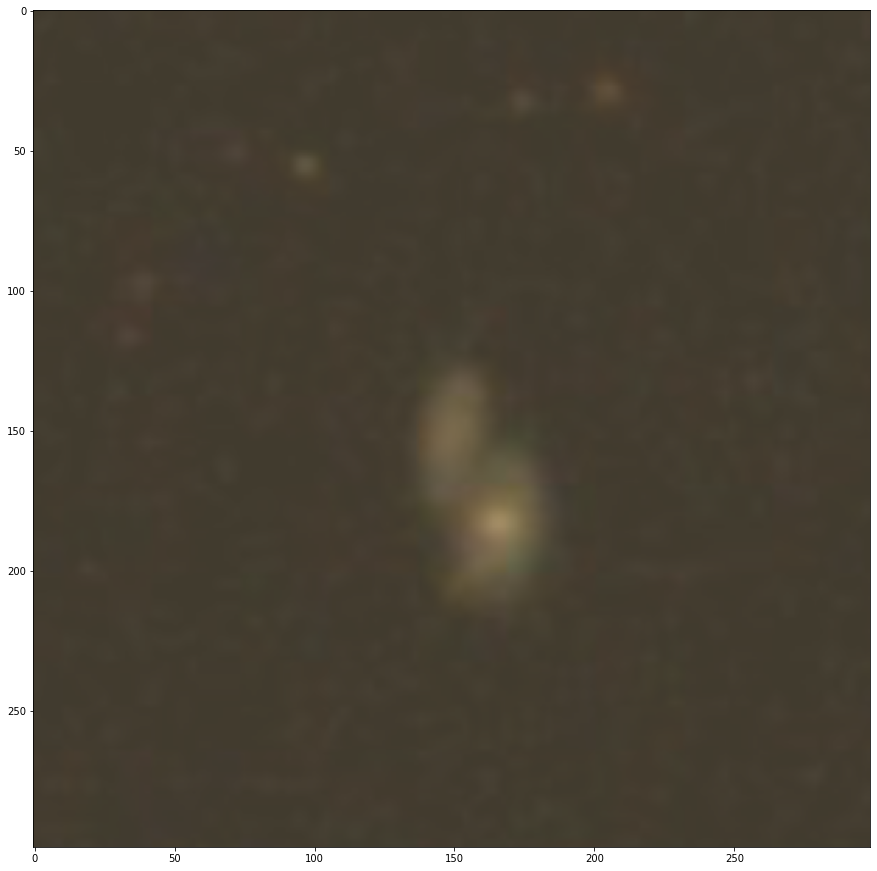

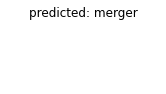

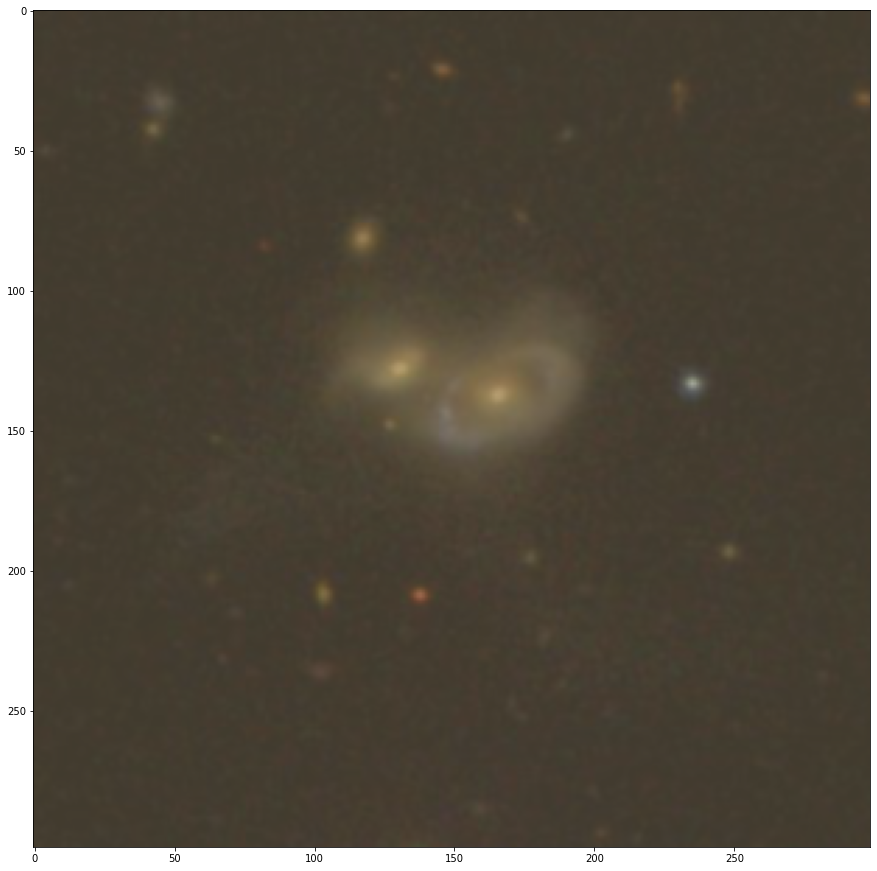

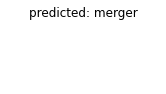

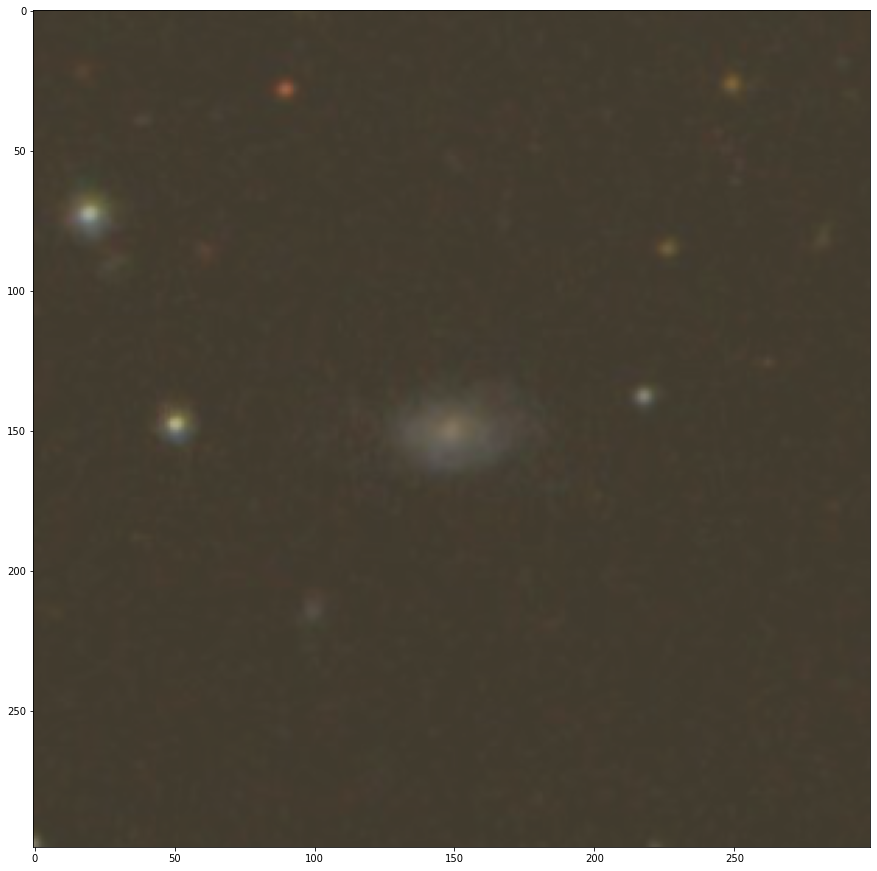

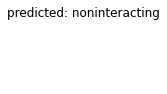

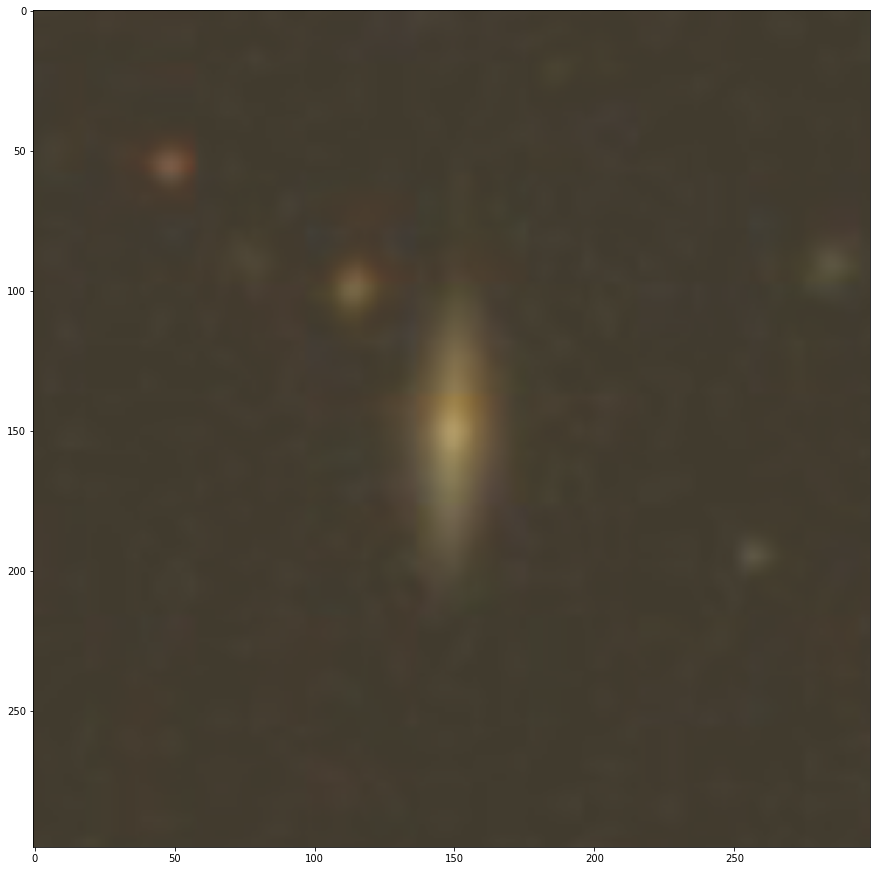

In [34]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
inps, labels_ = next(iter(test_loader))
print(labels_)

tensor([0, 0, 0, 0, 0, 1, 1, 0])


In [ ]:
test_loader.dataset.classes

['merger', 'noninteracting']

In [ ]:
len(targets_[targets_ == 1])

2500

In [36]:
# Testing loop
test_loader = dataloaders["test"]
correct, total = 0, 0

all_preds = []
all_targets = []
outs = []
probabilities = []

model_conv.eval()  # Set model to evaluation mode.
with torch.no_grad():
  
  # Iterate over the test data and generate predictions
  for i, data in enumerate(test_loader, 0):
    
    # Get inputs
    inputs, targets = data

    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Generate outputs
    outputs = model_conv(inputs)  # These are log probabilities
    ps = torch.exp(outputs)
    # topk, topclass = ps.topk(topk, dim=1) --> Since there are only two classes, we will not use it (k = 2).
    probabilities.append(ps)
    
    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    all_preds.append(predicted)
    all_targets.append(targets)
    outs.append(outputs.data)
    
  # Print accuracy
  print(f"Accuracy: {100 * correct / total}")

Accuracy: 79.1895947973987


In [37]:
print(f"Accuracy: {correct/total}")

Accuracy: 0.791895947973987


**Note**: `0` means merger and `1` means non-interacting

In [38]:
for pred in all_preds:
  pred = pred.cpu().numpy()

In [39]:
preds = np.hstack([pred.cpu().numpy() for pred in all_preds])
targets_ = np.hstack([target_.cpu().numpy() for target_ in all_targets])

In [40]:
!pip install plot-metric

In [41]:
from plot_metric.functions import BinaryClassification

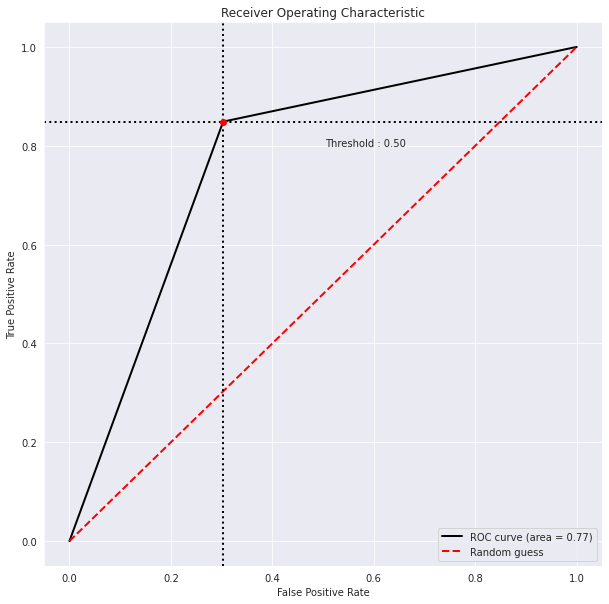

In [42]:
# Visualisation with plot_metric
bc = BinaryClassification(targets_, preds, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
conf_matrix = confusion_matrix(targets_, preds)
print(conf_matrix)

[[1044  454]
 [ 378 2122]]


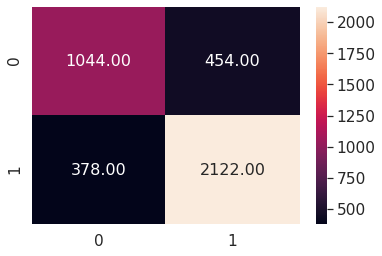

In [45]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(conf_matrix, range(2), range(2))

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".2f") # font size

plt.show()

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [47]:
precision = precision_score(targets_, preds, average='binary')
recall = recall_score(targets_, preds, average='binary')
f1_score = f1_score(targets_, preds, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.8237577639751553
Recall: 0.8488
F1 Score: 0.8360914105594955


In [77]:
ps_ = probabilities[0]
topk, topclass = ps_.topk(2, dim=1)
print(topk)
print("\n")
print(topclass)

tensor([[2.0963, 0.5802],
        [6.1454, 0.2298],
        [1.8358, 0.6114],
        [1.1735, 0.8924],
        [6.8967, 0.1865],
        [1.3066, 1.0738],
        [1.3159, 0.7626],
        [1.2079, 0.8508]], device='cuda:0')


tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], device='cuda:0')


In [62]:
cpu_probabilities = [prob.cpu() for prob in probabilities]

In [65]:
final_probs = np.vstack([prob.numpy() for prob in cpu_probabilities])

In [66]:
final_probs

array([[2.0962572 , 0.5801756 ],
       [6.145448  , 0.2297605 ],
       [0.61135566, 1.8357536 ],
       ...,
       [0.2079214 , 4.016045  ],
       [0.18431525, 6.222565  ],
       [0.2967351 , 3.460962  ]], dtype=float32)

In [63]:
with open("cpu_probabilities.txt", "w") as f:
  f.write("%s = %s\n" %("cpu_probabilities", cpu_probabilities))

In [57]:
with open("probabilities.txt", "w") as f:
  f.write("%s = %s\n" %("probabilities", probabilities))

In [80]:
final_probs.shape

(3998, 2)

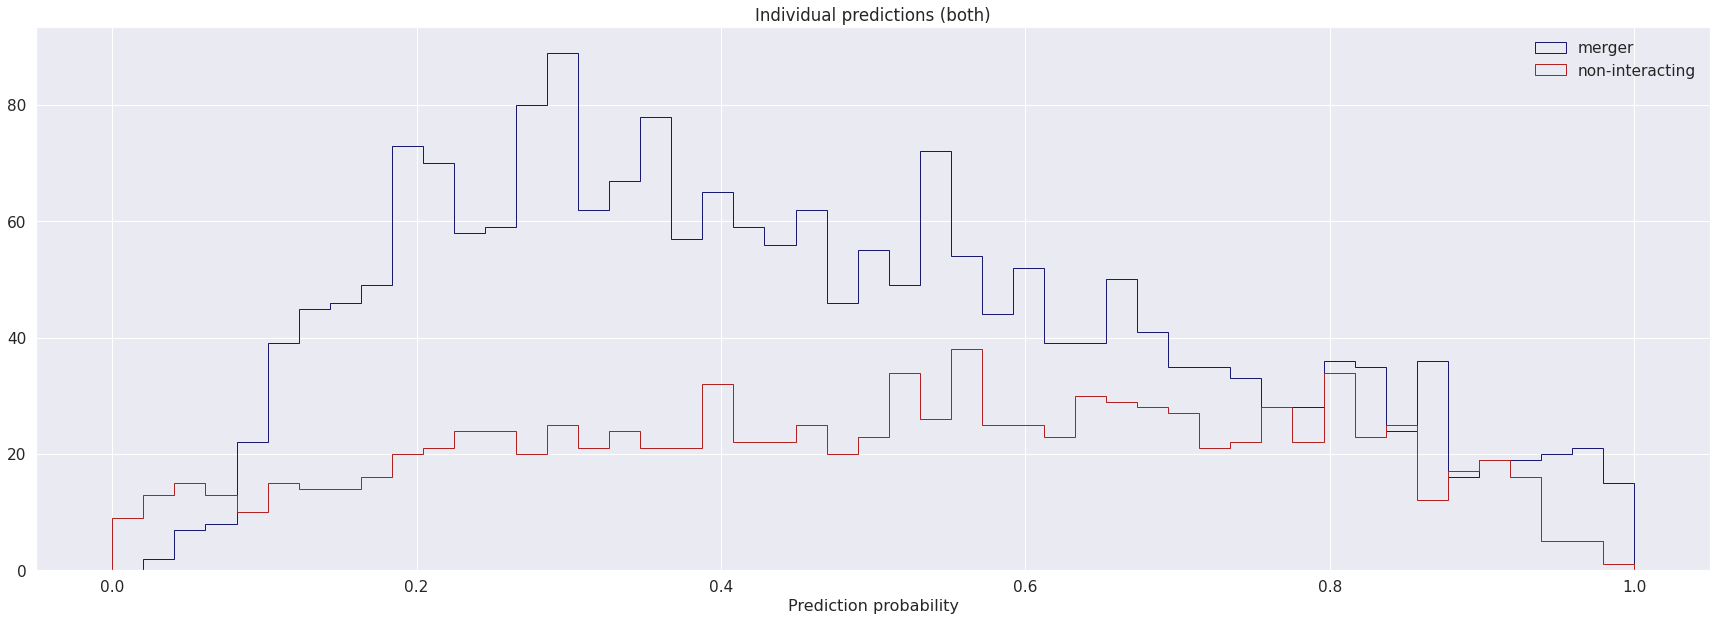

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 10));

hist_style_all = dict(histtype="step", color="darkgreen", label="All")
hist_style_class1 = dict(histtype="step", color="midnightblue", label="merger")
hist_style_class2 = dict(histtype="step", color="firebrick", label="non-interacting")

ax.hist(final_probs[:, 0][targets_.astype(bool)], bins=np.linspace(0, 1, 50),
        **hist_style_class1);
ax.hist((1 - final_probs[:, 1])[~(targets_.astype(bool))], bins=np.linspace(0, 1, 50),
        **hist_style_class2);

ax.set_xlabel("Prediction probability", fontsize=16);
ax.set_ylabel("", fontsize=16);
ax.set_title("Individual predictions (both)")
ax.legend(frameon=False);

The outputs of the deep convolutional network are log probabilities? To get the probabilites of prediction, we need to exponentiate these?